# Training Pipeline - U-Net for Cityscapes Segmentation

This notebook implements the complete training pipeline for semantic segmentation on the Cityscapes dataset.

## Objectives
- Create and compile the U-Net model
- Set up data generators with augmentation
- Train the model with callbacks
- Visualize predictions during training
- Monitor training metrics
- Save the best model


In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

# Load environment variables from .env file
try:
    from dotenv import load_dotenv
    # Try to load .env from project root (parent of notebooks/)
    # In notebooks, we're in notebooks/ directory, so go up one level
    env_path = Path('..') / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"✓ Loaded environment variables from {env_path.resolve()}")
    else:
        # Try current directory (notebooks/)
        env_path = Path('.env')
        if env_path.exists():
            load_dotenv(env_path)
            print(f"✓ Loaded environment variables from {env_path.resolve()}")
        else:
            # Try project root from absolute path
            import os
            project_root = Path(os.path.abspath('..'))
            env_path = project_root / '.env'
            if env_path.exists():
                load_dotenv(env_path)
                print(f"✓ Loaded environment variables from {env_path}")
            else:
                print("⚠ .env file not found. Make sure it exists in the project root.")
except ImportError:
    print("⚠ python-dotenv not installed. Install with: pip install python-dotenv")
except Exception as e:
    print(f"⚠ Could not load .env file: {e}")

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# MLflow tracking
try:
    from src.mlflow_tracking import MLflowTracker, setup_mlflow_tracking
    from src.callbacks import MLflowCallback, MLflowVisualizationCallback, MLflowModelCallback
    MLFLOW_AVAILABLE = True
    print("✓ MLflow tracking available")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠ MLflow not available. Install with: pip install mlflow")

# Force reload of modules if they were already imported (useful when modifying source files)
if 'src.callbacks' in sys.modules:
    importlib.reload(sys.modules['src.callbacks'])
if 'src.azure_storage' in sys.modules:
    importlib.reload(sys.modules['src.azure_storage'])

# TensorFlow/Keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard
)

# Project modules
from src.model_architecture import build_unet, build_unet_small, build_unet_mobilenet
from src.metrics import combined_loss, DiceCoefficient, IoUCoefficient
from src.data_generator import create_data_generators
from src.augmentations import get_training_augmentation, get_light_augmentation
from src.callbacks import (
    PredictionVisualizationFromGenerator,
    TrainingTimeCallback,
    AzureUploadCallback,
    AzureModelCheckpoint
)
from src.azure_storage import AzureStorageManager

# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


✓ Loaded environment variables from /Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System/.env


/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System/.venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✓ MLflow tracking available
Libraries imported successfully!
TensorFlow version: 2.15.1


## 1. Configuration

Define hyperparameters and training settings.


In [2]:
# Training configuration
IMAGE_SIZE = (256, 512)  # (height, width)
BATCH_SIZE = 8  # Adjust based on GPU memory (8, 16, 32, etc.)
N_CLASSES = 8
EPOCHS = 3
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2

# Model configuration
USE_SMALL_MODEL = True  # Set to True for faster
USE_MOBILENET_BACKBONE = True
INITIAL_FILTERS = 64  # Number of filters in first layer
MOBILENET_ALPHA = 1.0  # MobileNet width multiplier (1.0, 0.75, 0.5, 0.35)
MOBILENET_WEIGHTS = None  # Pre-trained weights: "imagenet" or None
DECODER_FILTERS = 256  # Number of filters in decoder (for MobileNet backbone)

# Augmentation
USE_AUGMENTATION = False
USE_LIGHT_AUGMENTATION = False  # Set to True for faster training

# Callbacks configuration
VISUALIZE_PREDICTIONS = True
VIZ_FREQUENCY = 1  # Visualize every N epochs
EARLY_STOPPING_PATIENCE = 2
REDUCE_LR_PATIENCE = 5

# Paths
MODEL_SAVE_PATH = "models/unet_mobilenet_cityscapes.h5"
OUTPUT_DIR = "outputs/training_visualizations"
LOGS_DIR = "logs"

# Azure Storage configuration
USE_AZURE_STORAGE = False  # Set to True to enable Azure uploads
AZURE_CONTAINER_NAME = "training-outputs"
AZURE_RUN_NAME = "MobileNetV2"  # Optional: name for this training run (e.g., "experiment_001")
AZURE_UPLOAD_FREQUENCY = 1  # Upload every N epochs (1 = every epoch)
AZURE_ONLY_MODE = True  # Set to True to save ONLY to Azure (no local saves)
AZURE_CREATE_CONTAINER = False  # Set to True to auto-create container (requires permissions)
                                 # If False, container must exist already

# MLflow configuration
USE_MLFLOW = True  # Set to True to enable MLflow tracking
mlflow_tracker = None
# MLflow configuration from environment variables
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI', 'http://localhost:5001')
if MLFLOW_TRACKING_URI and ' ' in MLFLOW_TRACKING_URI:
    MLFLOW_TRACKING_URI = MLFLOW_TRACKING_URI.split(' ')[0]
MLFLOW_EXPERIMENT_NAME = os.getenv('MLFLOW_EXPERIMENT_NAME', 'unet_cityscapes_segmentation')

# Create directories
Path("models").mkdir(exist_ok=True)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(LOGS_DIR).mkdir(exist_ok=True)

print("Configuration:")
print(f"  Image size: {IMAGE_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
if USE_MOBILENET_BACKBONE:
    print(f"  Model: U-Net with MobileNetV2 backbone (alpha={MOBILENET_ALPHA})")
else:
    print(f"  Model: {'Small' if USE_SMALL_MODEL else 'Full'} U-Net")
print(f"  Augmentation: {'Light' if USE_LIGHT_AUGMENTATION else 'Full' if USE_AUGMENTATION else 'None'}")
print(f"  Azure Storage: {'Enabled' if USE_AZURE_STORAGE else 'Disabled'}")
if USE_AZURE_STORAGE:
    print(f"    Container: {AZURE_CONTAINER_NAME}")
    print(f"    Run name: {AZURE_RUN_NAME or 'default'}")
    print(f"    Upload frequency: every {AZURE_UPLOAD_FREQUENCY} epoch(s)")
    print(f"    Azure-only mode: {'Yes (no local saves)' if AZURE_ONLY_MODE else 'No (local + Azure)'}")
    print(f"    Auto-create container: {'Yes' if AZURE_CREATE_CONTAINER else 'No (must exist)'}")
if USE_MLFLOW and MLFLOW_AVAILABLE:
    # Initialize MLflow tracking
    mlflow_tracker = setup_mlflow_tracking(
        tracking_uri=MLFLOW_TRACKING_URI,
        experiment_name=MLFLOW_EXPERIMENT_NAME
    )
    print("✓ MLflow experiment tracking enabled")
    print(f"    MLflow tracking URI: {MLFLOW_TRACKING_URI}")
    print(f"    MLflow experiment name: {MLFLOW_EXPERIMENT_NAME}")
else:
    print("⚠ MLflow not available. Install with: pip install mlflow")
    print(f"Experiment : {MLFLOW_EXPERIMENT_NAME}")
    print(f"Tracking URI: {MLFLOW_TRACKING_URI}")

Configuration:
  Image size: (256, 512)
  Batch size: 8
  Epochs: 3
  Learning rate: 0.0001
  Model: U-Net with MobileNetV2 backbone (alpha=1.0)
  Augmentation: None
  Azure Storage: Disabled
✓ Created new MLflow experiment: segmentation-UNet+MobileNet
✓ MLflow experiment tracking enabled
    MLflow tracking URI: http://localhost:5001
    MLflow experiment name: segmentation-UNet+MobileNet


## 2. Create Data Generators

Set up training and validation data generators with optional augmentation.


In [3]:
# Create augmentation pipeline
if USE_AUGMENTATION:
    if USE_LIGHT_AUGMENTATION:
        train_aug = get_light_augmentation(image_size=IMAGE_SIZE)
        print("Using light augmentation")
    else:
        train_aug = get_training_augmentation(image_size=IMAGE_SIZE)
        print("Using full augmentation")
else:
    train_aug = None
    print("No augmentation")

# Create data generators
print("\nCreating data generators...")
train_gen, val_gen = create_data_generators(
    batch_size=BATCH_SIZE,
    dim=IMAGE_SIZE,
    augmentation=train_aug,
    normalize=True,
    validation_split=VALIDATION_SPLIT,
    max_samples=100  # Use all data, or set a limit (e.g., 1000) for testing
)

print(f"\nData generators created:")
print(f"  Training batches per epoch: {len(train_gen)}")
print(f"  Validation batches per epoch: {len(val_gen)}")
print(f"  Samples per batch: {BATCH_SIZE}")


No augmentation

Creating data generators...
Using a subset of 100 samples from the full partition.
Total samples used: 100
Training samples: 80
Validation samples: 20

Data generators created:
  Training batches per epoch: 10
  Validation batches per epoch: 2
  Samples per batch: 8


## 3. Test Data Generator

Let's verify that the data generator works correctly by visualizing a batch.


Batch shape - Images: (8, 256, 512, 3), Masks: (8, 256, 512)
Image dtype: float32, range: [0.00, 1.00]
Mask dtype: uint8, unique values: [0 1 2 3 4 5 6 7]


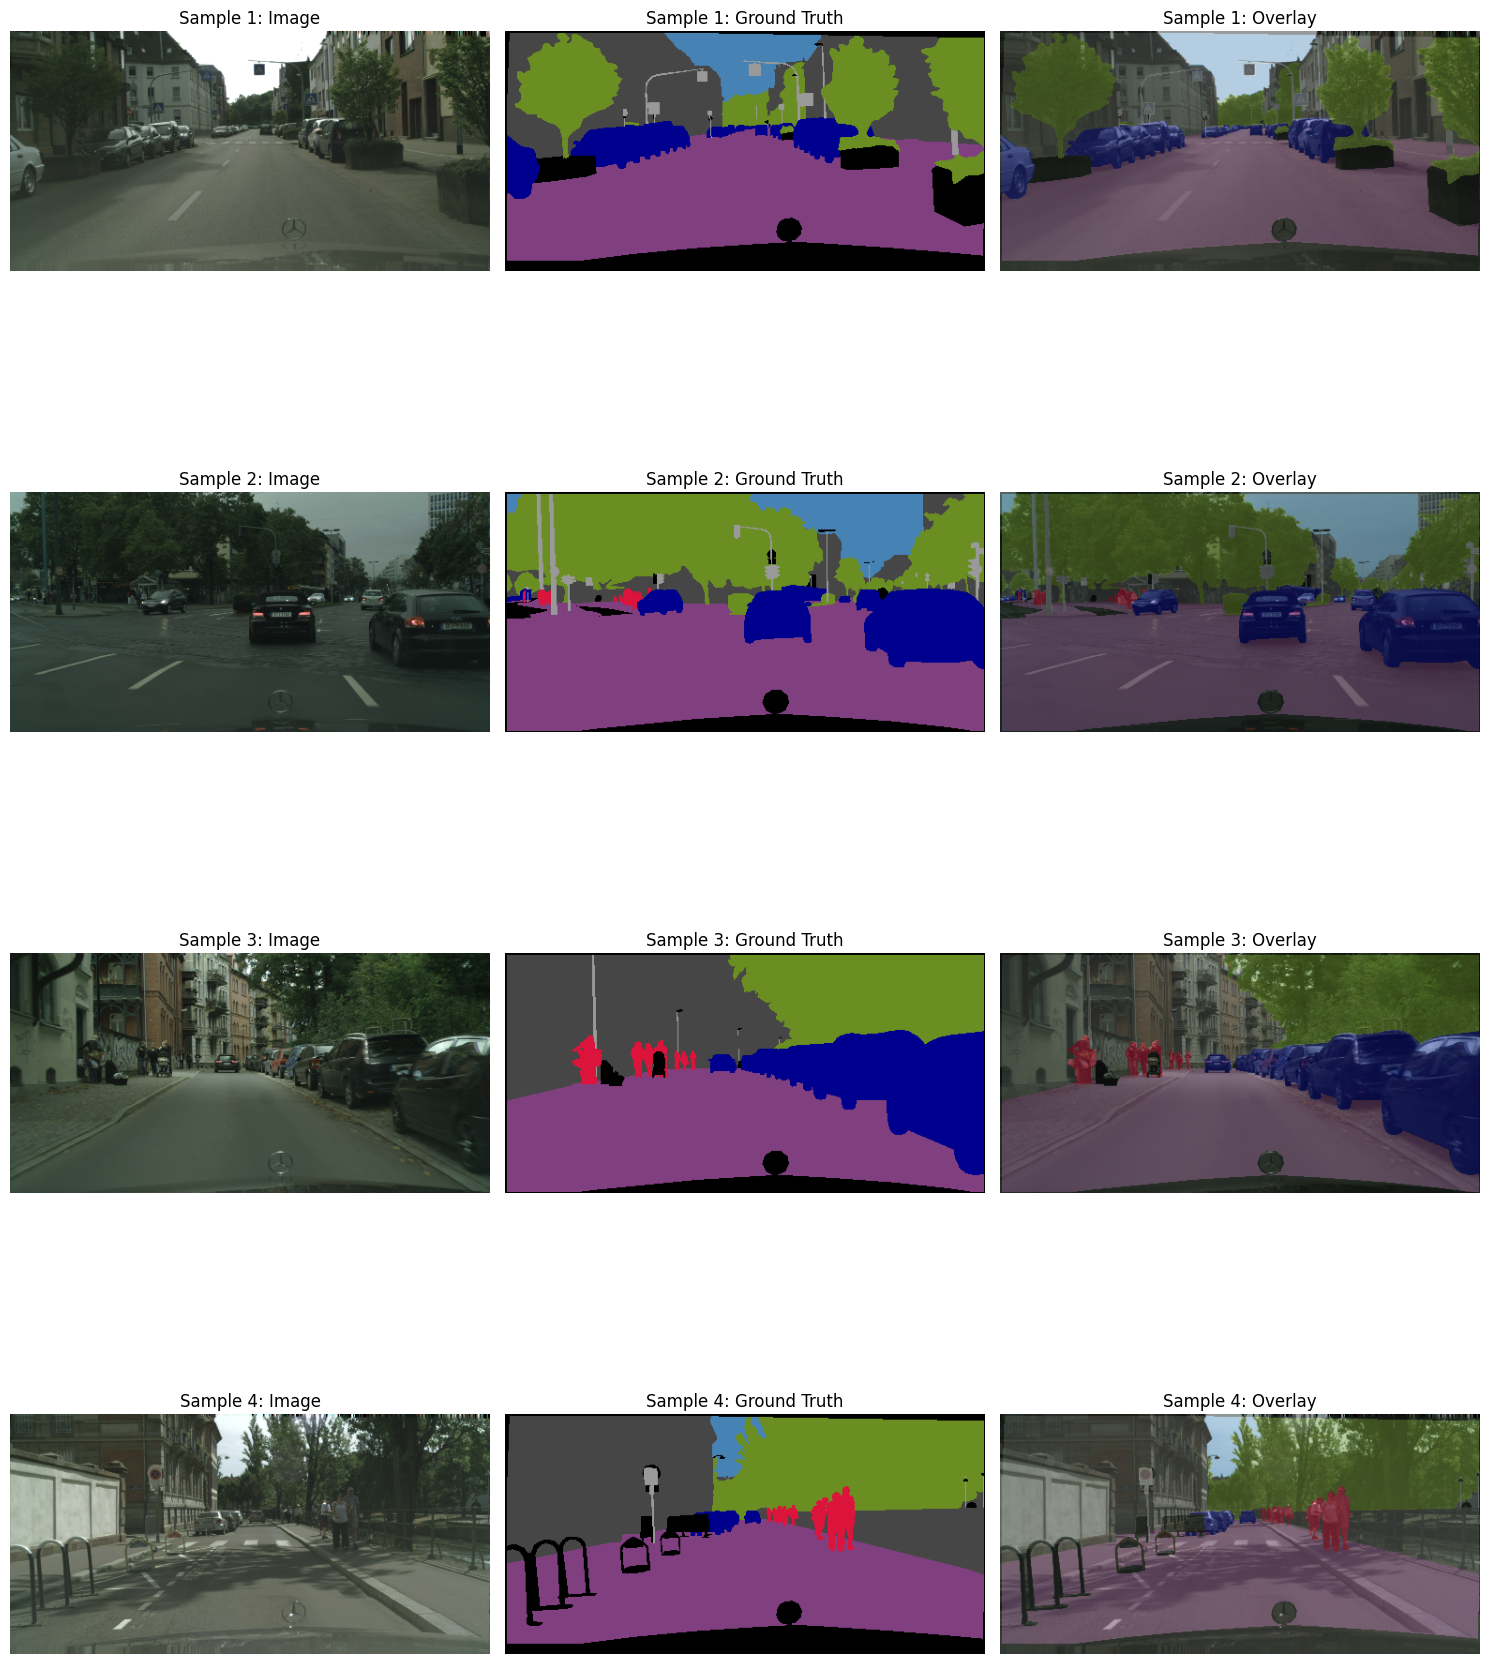

Data generator test successful!


In [4]:
# Test the data generator
from src.utils import mask_to_colored

# Get a batch
images, masks = train_gen[0]

print(f"Batch shape - Images: {images.shape}, Masks: {masks.shape}")
print(f"Image dtype: {images.dtype}, range: [{images.min():.2f}, {images.max():.2f}]")
print(f"Mask dtype: {masks.dtype}, unique values: {np.unique(masks)}")

# Visualize a few samples
n_samples = min(4, len(images))
fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))

if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Denormalize image
    img = (images[i] * 255).astype(np.uint8) if images[i].max() <= 1.0 else images[i].astype(np.uint8)
    mask = masks[i].astype(np.uint8)
    colored_mask = mask_to_colored(mask)

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Sample {i+1}: Image")
    axes[i, 0].axis('off')

    # Ground truth mask
    axes[i, 1].imshow(colored_mask)
    axes[i, 1].set_title(f"Sample {i+1}: Ground Truth")
    axes[i, 1].axis('off')

    # Overlay
    overlay = (img * 0.6 + colored_mask * 0.4).astype(np.uint8)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f"Sample {i+1}: Overlay")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
print("Data generator test successful!")


## 4. Build and Compile Model

Create the U-Net architecture and compile it with loss and metrics.


In [5]:
# Build model
print("Building model...")
if USE_MOBILENET_BACKBONE:
    model = build_unet_mobilenet(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        alpha=MOBILENET_ALPHA,
        weights=MOBILENET_WEIGHTS,
        decoder_filters=DECODER_FILTERS
    )
    print(f"Using U-Net with MobileNetV2 backbone (alpha={MOBILENET_ALPHA})")
elif USE_SMALL_MODEL:
    model = build_unet_small(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=32
    )
    print("Using small U-Net model")
else:
    model = build_unet(
        input_shape=(*IMAGE_SIZE, 3),
        n_classes=N_CLASSES,
        filters=INITIAL_FILTERS
    )
    print("Using full U-Net model")

# Compile model
model.compile(
    optimizer=legacy.Adam(learning_rate=LEARNING_RATE),
    loss=combined_loss,
    metrics=[
        'accuracy',
        DiceCoefficient(),
        IoUCoefficient()
    ]
)

print(f"Model output shape: {model.output.shape}")

print("\nModel compiled successfully!")
print(f"\nModel summary:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


Building model...
Using U-Net with MobileNetV2 backbone (alpha=1.0)
Model output shape: (None, 256, 512, 8)

Model compiled successfully!

Model summary:
Model: "U-Net-MobileNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 256, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                             

## 5.MLFLOW Setup

- Initialize MLflow tracker
- Start run with dynamic name
- Log configuration
- Display connexion informations

In [6]:
from datetime import datetime

if USE_MLFLOW and mlflow_tracker:
    # Start MLflow run
    run_name = f"UNet_MobileNetV2_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    mlflow_tracker.start_run(run_name=run_name)

    # Log configuration parameters
    mlflow_tracker.log_params({
        "image_size": str(IMAGE_SIZE),
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "learning_rate": LEARNING_RATE,
        "model_type": "MobileNetV2" if USE_MOBILENET_BACKBONE else "SmallUNet",
        "mobilenet_alpha": MOBILENET_ALPHA,
        "augmentation": "Light" if USE_LIGHT_AUGMENTATION else "Full" if USE_AUGMENTATION else "None"
    })

    # Log system info
    mlflow_tracker.log_system_info()
else:
    print("MLflow tracking is disabled or tracker not initialized.")

✓ Started MLflow run: UNet_MobileNetV2_20260116_135919 (ID: ecec400aeb8541b897168f36f5e16ad7)
✓ Logged 7 parameters to MLflow
✓ Logged system information to MLflow


## 6. Set Up Callbacks

Configure callbacks for model checkpointing, early stopping, learning rate reduction, and visualization.


In [7]:
# Create callbacks list
callbacks = []

# Model checkpoint - save best model
if USE_AZURE_STORAGE and AZURE_ONLY_MODE:
    # Save directly to Azure only (no local save)
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        from pathlib import Path
        model_blob_name = f"model/{Path(MODEL_SAVE_PATH).name}"
        azure_checkpoint = AzureModelCheckpoint(
            azure_manager=azure_manager,
            blob_name=model_blob_name,
            monitor='val_iou_coefficient',
            save_best_only=True,
            mode='max',
            verbose=1,
            run_name=AZURE_RUN_NAME
        )
        callbacks.append(azure_checkpoint)
        print("Using Azure-only model checkpoint (no local saves)")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure checkpoint: {e}")
        print("Falling back to local checkpoint...")
        callbacks.append(
            ModelCheckpoint(
                MODEL_SAVE_PATH,
                monitor='val_iou_coefficient',
                save_best_only=True,
                mode='max',
                verbose=1,
                save_weights_only=False
            )
        )
else:
    # Save locally (and optionally upload to Azure later)
    callbacks.append(
        ModelCheckpoint(
            MODEL_SAVE_PATH,
            monitor='val_iou_coefficient',
            save_best_only=True,
            mode='max',
            verbose=1,
            save_weights_only=False
        )
    )

# Early stopping
callbacks.append(
    EarlyStopping(
        monitor='val_iou_coefficient',
        patience=EARLY_STOPPING_PATIENCE,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
)

# Reduce learning rate on plateau
callbacks.append(
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=REDUCE_LR_PATIENCE,
        min_lr=1e-7,
        verbose=1
    )
)

# TensorBoard
callbacks.append(
    TensorBoard(
        log_dir=LOGS_DIR,
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
)

# Training time tracking callback
time_callback = TrainingTimeCallback()
callbacks.append(time_callback)

# Prediction visualization callback
if VISUALIZE_PREDICTIONS:
    viz_callback = PredictionVisualizationFromGenerator(
        validation_generator=val_gen,
        output_dir=OUTPUT_DIR,
        num_samples=4,
        frequency=VIZ_FREQUENCY
    )
    callbacks.append(viz_callback)
    print(f"Visualization callback added (every {VIZ_FREQUENCY} epochs)")

# Azure Storage upload callback
# Only add if not in Azure-only mode (in Azure-only mode, checkpoints are already saved to Azure)
if USE_AZURE_STORAGE and not AZURE_ONLY_MODE:
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        azure_callback = AzureUploadCallback(
            azure_manager=azure_manager,
            model_path=MODEL_SAVE_PATH,
            output_dir=OUTPUT_DIR,
            logs_dir=LOGS_DIR,
            run_name=AZURE_RUN_NAME,
            upload_frequency=AZURE_UPLOAD_FREQUENCY
        )
        callbacks.append(azure_callback)
        print(f"Azure upload callback added (every {AZURE_UPLOAD_FREQUENCY} epoch(s))")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure Storage: {e}")
        print("Continuing without Azure upload...")
elif USE_AZURE_STORAGE and AZURE_ONLY_MODE:
    # In Azure-only mode, still upload outputs and logs (but not model, already handled)
    try:
        azure_manager = AzureStorageManager(
            container_name=AZURE_CONTAINER_NAME,
            create_container_if_not_exists=AZURE_CREATE_CONTAINER
        )
        azure_callback = AzureUploadCallback(
            azure_manager=azure_manager,
            model_path=None,  # Model already saved by AzureModelCheckpoint
            output_dir=OUTPUT_DIR,
            logs_dir=LOGS_DIR,
            run_name=AZURE_RUN_NAME,
            upload_frequency=AZURE_UPLOAD_FREQUENCY
        )
        callbacks.append(azure_callback)
        print(f"Azure upload callback added for outputs/logs (every {AZURE_UPLOAD_FREQUENCY} epoch(s))")
    except Exception as e:
        print(f"Warning: Failed to initialize Azure Storage: {e}")
        print("Continuing without Azure upload...")

if USE_MLFLOW and mlflow_tracker and MLFLOW_AVAILABLE:
    # Main metrics callback
    callbacks.append(MLflowCallback(tracker=mlflow_tracker))

    # Visualization callback for MLflow
    if VISUALIZE_PREDICTIONS:
        callbacks.append(MLflowVisualizationCallback(
            mlflow_tracker=mlflow_tracker,
            visualization_dir=OUTPUT_DIR
        ))

    # Model logging callback
    callbacks.append(MLflowModelCallback(
        mlflow_tracker=mlflow_tracker,
        model_name="unet_mobilenet_cityscapes"
    ))
    print("✓ MLflow callbacks added")

print(f"\nTotal callbacks: {len(callbacks)}")
print("Callbacks configured:")
for i, cb in enumerate(callbacks, 1):
    print(f"  {i}. {cb.__class__.__name__}")


Visualization callback initialized (from generator):
  - Output directory: outputs/training_visualizations
  - Number of samples: 4
  - Frequency: every 1 epochs
Visualization callback added (every 1 epochs)
✓ MLflow callbacks added

Total callbacks: 9
Callbacks configured:
  1. ModelCheckpoint
  2. EarlyStopping
  3. ReduceLROnPlateau
  4. TensorBoard
  5. TrainingTimeCallback
  6. PredictionVisualizationFromGenerator
  7. MLflowCallback
  8. MLflowVisualizationCallback
  9. MLflowModelCallback


## 6. Train the Model

Start the training process. The model will automatically:
- Save the best model based on validation IoU
- Stop early if no improvement
- Reduce learning rate when plateau is reached
- Visualize predictions periodically


In [8]:
# Train the model
print("Starting training...")
print("=" * 60)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


# End MLflow run
if USE_MLFLOW and mlflow_tracker:
    mlflow_tracker.end_run()
print("=" * 60)
print("Training completed!")
print(f"\nBest model saved to: {MODEL_SAVE_PATH}")
if VISUALIZE_PREDICTIONS:
    print(f"Visualizations saved to: {OUTPUT_DIR}/")
print(f"TensorBoard logs saved to: {LOGS_DIR}/")


Starting training...
Training time tracking started
Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 1.5249 - accuracy: 0.1550 - dice_coefficient: 0.1365 - iou_coefficient: 0.0733
Epoch 1: val_iou_coefficient improved from -inf to 0.06676, saving model to models/unet_mobilenet_cityscapes.h5


/Users/ikusawalaetitia/Documents/oc-projects/python/aiengineer/P8-Image-Processing-for-Autonomous-Vehicle-Embedded-System/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  Saved visualization: outputs/training_visualizations/epoch_001.png
10/10 [==============================] - 20s 2s/step - loss: 1.5249 - accuracy: 0.1550 - dice_coefficient: 0.1365 - iou_coefficient: 0.0733 - val_loss: 1.4765 - val_accuracy: 0.0577 - val_dice_coefficient: 0.1252 - val_iou_coefficient: 0.0668 - lr: 1.0000e-04 - epoch_time: 17.9560 - total_training_time: 17.9560 - avg_epoch_time: 17.9560
Epoch 2/3
10/10 [==============================] - ETA: 0s - loss: 1.4113 - accuracy: 0.2866 - dice_coefficient: 0.1703 - iou_coefficient: 0.0931
Epoch 2: val_iou_coefficient improved from 0.06676 to 0.06788, saving model to models/unet_mobilenet_cityscapes.h5
  Saved visualization: outputs/training_visualizations/epoch_002.png
10/10 [==============================] - 16s 2s/step - loss: 1.4113 - accuracy: 0.2866 - dice_coefficient: 0.1703 - iou_coefficient: 0.0931 - val_loss: 1.4680 - val_accuracy: 0.3993 - val_dice_coefficient: 0.1271 - val_iou_coefficient: 0.0679 - lr: 1.0000e-04 - 

2026/01/16 14:02:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/16 14:02:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Training completed!
  Total training time: 51.66 seconds (0.86 minutes)
  Average time per epoch: 15.72 seconds (0.26 minutes)
  Number of epochs: 3
INFO:tensorflow:Assets written to: /var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/tmpetz59mog/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/tmpetz59mog/model/data/model/assets
2026/01/16 14:02:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/4f/ml64c07d1zsg_jvvydhyltjr0000gn/T/tmpetz59mog/model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.1', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2026/01/16 14:02:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


✓ Logged model 'unet_mobilenet_cityscapes_final' to MLflow
🏃 View run UNet_MobileNetV2_20260116_135919 at: http://localhost:5001/#/experiments/1/runs/ecec400aeb8541b897168f36f5e16ad7
🧪 View experiment at: http://localhost:5001/#/experiments/1
✓ Ended MLflow run
Training completed!

Best model saved to: models/unet_mobilenet_cityscapes.h5
Visualizations saved to: outputs/training_visualizations/
TensorBoard logs saved to: logs/


## 7. Visualize Training History

Plot training curves to analyze model performance.


In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Dice Coefficient
axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
axes[1, 0].set_title('Dice Coefficient')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Dice')
axes[1, 0].legend()
axes[1, 0].grid(True)

# IoU Coefficient
axes[1, 1].plot(history.history['iou_coefficient'], label='Training IoU')
axes[1, 1].plot(history.history['val_iou_coefficient'], label='Validation IoU')
axes[1, 1].set_title('IoU Coefficient')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('outputs/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"  Loss: {history.history['loss'][-1]:.4f}")
print(f"  Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Dice: {history.history['dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['iou_coefficient'][-1]:.4f}")

print("\nFinal Validation Metrics:")
print(f"  Loss: {history.history['val_loss'][-1]:.4f}")
print(f"  Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Dice: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"  IoU: {history.history['val_iou_coefficient'][-1]:.4f}")

# Best validation metrics
best_epoch = np.argmax(history.history['val_iou_coefficient'])
print(f"\nBest Validation IoU at Epoch {best_epoch + 1}:")
print(f"  IoU: {history.history['val_iou_coefficient'][best_epoch]:.4f}")
print(f"  Dice: {history.history['val_dice_coefficient'][best_epoch]:.4f}")
print(f"  Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

# Training time metrics
if hasattr(time_callback, 'total_time') and time_callback.total_time > 0:
    total_time = time_callback.total_time
    avg_epoch_time = np.mean(time_callback.epoch_times) if time_callback.epoch_times else 0.0
    print(f"\nTraining Time Metrics:")
    print(f"  Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"  Average time per epoch: {avg_epoch_time:.2f} seconds ({avg_epoch_time/60:.2f} minutes)")
    print(f"  Number of epochs: {len(time_callback.epoch_times)}")
    if len(time_callback.epoch_times) > 0:
        print(f"  Fastest epoch: {min(time_callback.epoch_times):.2f} seconds")
        print(f"  Slowest epoch: {max(time_callback.epoch_times):.2f} seconds")


## 8. Visualize Predictions on Validation Set

Make predictions on validation samples and visualize the results.


In [ ]:
# Get a batch from validation set
from src.utils import mask_to_colored

val_images, val_masks = val_gen[0]

# Make predictions
print("Making predictions on validation set...")
predictions = model.predict(val_images, verbose=1)
predicted_masks = np.argmax(predictions, axis=-1)

# Visualize predictions
n_samples = min(4, len(val_images))
fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4 * n_samples))

if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Denormalize image
    img = (val_images[i] * 255).astype(np.uint8) if val_images[i].max() <= 1.0 else val_images[i].astype(np.uint8)
    true_mask = val_masks[i].astype(np.uint8)
    pred_mask = predicted_masks[i].astype(np.uint8)

    # Convert masks to colored
    true_colored = mask_to_colored(true_mask)
    pred_colored = mask_to_colored(pred_mask)

    # Create overlay
    overlay = (img * 0.6 + pred_colored * 0.4).astype(np.uint8)

    # Original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Sample {i+1}: Original")
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(true_colored)
    axes[i, 1].set_title(f"Sample {i+1}: Ground Truth")
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(pred_colored)
    axes[i, 2].set_title(f"Sample {i+1}: Prediction")
    axes[i, 2].axis('off')

    # Overlay
    axes[i, 3].imshow(overlay)
    axes[i, 3].set_title(f"Sample {i+1}: Overlay")
    axes[i, 3].axis('off')

plt.suptitle("Final Predictions on Validation Set", fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('outputs/final_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Predictions visualized!")


## 10. Upload Outputs to Azure (Optional)

If Azure Storage is enabled, outputs are automatically uploaded during training.
You can also manually upload outputs here if needed.


In [ ]:
# Manual upload to Azure (optional)
# Uncomment and configure if you want to upload outputs manually

# from src.azure_storage import upload_to_azure
#
# # Upload all training outputs
# results = upload_to_azure(
#     model_path=MODEL_SAVE_PATH,
#     output_dir=OUTPUT_DIR,
#     logs_dir=LOGS_DIR,
#     run_name=AZURE_RUN_NAME or "manual_upload",
#     container_name=AZURE_CONTAINER_NAME
# )
#
# print("Upload results:")
# print(f"  Model URL: {results['model_url']}")
# print(f"  Outputs: {len(results['outputs_urls'])} files uploaded")
# print(f"  Logs: {len(results['logs_urls'])} files uploaded")


## 9. Summary

Training completed! The best model has been saved and can be used for inference.

### Next Steps:
1. Evaluate the model on test set (if available)
2. Calculate per-class IoU metrics
3. Create confusion matrix
4. Deploy the model via API
5. Create web application for demonstration
